# <B> CREDIT CARD FRAUD DETECTION AT CAPITAL ONE </B>

In [15]:
import json
from datetime import timedelta
import re
import wget
from time import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from category_encoders import OneHotEncoder,CountEncoder,TargetEncoder

from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Q.1 - Load

In [16]:
url = 'https://github.com/CapitalOneRecruiting/DS/raw/master/transactions.zip'
filename = wget.download(url)

100% [....................................................] 30522086 / 30522086

In [4]:
!unzip transactions.zip

Archive:  transactions.zip
replace transactions.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [17]:
f = open('transactions.txt','r')

transactions = list()

for line in f:
    transactions.append(json.loads(line))

In [18]:
transactions = pd.DataFrame(transactions)

Data structure - 29 columns and ~786k rows

In [19]:
transactions.shape

(786363, 29)

In [20]:
transactions.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,,0.0,,,,False,,,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,,0.0,,,,True,,,False,False


The data is highly imbalanced, with 98.4% of the transactions non-fraudulent.

In [21]:
transactions.isFraud.value_counts() / transactions.isFraud.value_counts().sum()

False    0.98421
True     0.01579
Name: isFraud, dtype: float64

In [22]:
transactions.describe()

,creditLimit,availableMoney,transactionAmount,currentBalance
count,786363.000000,786363.000000,786363.000000,786363.000000
mean,10759.464459,6250.725369,136.985791,4508.739089
std,11636.174890,8880.783989,147.725569,6457.442068
min,250.000000,-1005.630000,0.000000,0.000000
25%,5000.000000,1077.420000,33.650000,689.910000
50%,7500.000000,3184.860000,87.900000,2451.760000
75%,15000.000000,7500.000000,191.480000,5291.095000
max,50000.000000,50000.000000,2011.540000,47498.810000


It is interesting to see how there are definite outliers in each of the numeric features. Outlier removal could be part of our sampling strategy, 
given that the target doesn't depend on them. 

In [23]:
transactions.dtypes

accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
echoBuffer                   object
currentBalance              float64
merchantCity                 object
merchantState                object
merchantZip                  object
cardPresent                    bool
posOnPremises                object
recurringAuthInd             object
expirationDateKeyInMatch    

In [24]:
transactions.describe(include = ['O'])

,accountNumber,customerId,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,...,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,merchantCity,merchantState,merchantZip,posOnPremises,recurringAuthInd
count,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,...,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363
unique,5000,5000,776637,2490,5,5,6,4,19,165,...,899,976,5246,4,1,1,1,1,1,1
top,380680241,380680241,2016-12-25T14:04:15,Uber,US,US,05,01,online_retail,03/2029,...,869,869,593,PURCHASE,,,,,,
freq,32850,32850,4,25613,774709,778511,315035,628787,202156,5103,...,33749,33424,32946,745193,786363,786363,786363,786363,786363,786363


This basic description helps us to see how the 700k data points are spread amongst just 5000 accounts, It is also interesting to see the Top merchant as well as merchant category that is prevelant. As expected most of the transactions are of type PURCHASE.

# Q.2 Plot

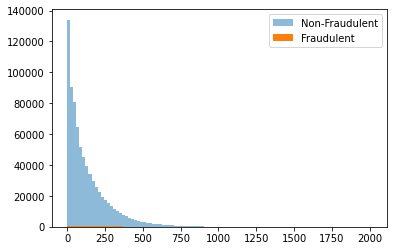

In [25]:
bins = 100
plt.hist(transactions[transactions.isFraud == False].transactionAmount, bins, alpha=0.5, label='Non-Fraudulent')
plt.hist(transactions[transactions.isFraud == True].transactionAmount,bins, alpha=1, label='Fraudulent')
plt.legend(loc='upper right')
plt.show()

The class imbalance makes it very difficult to say anythin with conviction about the distribution of fraudulent data, except that extremely high values are not as frequent as they are in the no-fraudulent case.

Additional plots and interesting Hypotheses on each feature can be found in section 4, before modeling, as we investigate into the usefulness of each feature.

<u> Code to clean features that do not add value </u>

In [26]:
columns_with_cardinality = list()
for c in transactions.columns:
    if len(transactions[c].unique()) == 1:
        columns_with_cardinality.append(c)
        
transactions.drop(columns_with_cardinality,inplace = True,axis = 1)

In [27]:
transactions.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False
2,737265056,737265056,5000.0,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
3,737265056,737265056,5000.0,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,...,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,False,False,False
4,830329091,830329091,5000.0,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,...,2015-08-06,2015-08-06,885,885,3143,PURCHASE,0.0,True,False,False


<p> The cells below some initial data exploration, like re-checking some of the unique values, and gaining some insight from just the values of a few features. </p>

In [28]:
len(transactions.accountNumber.unique())

5000

In [29]:
len(transactions.customerId.unique())

5000

Test to see if each customer is mapped to one account

In [30]:
(transactions.customerId != transactions.accountNumber).sum()

0

In [31]:
transactions.merchantCountryCode.value_counts() / transactions.merchantCountryCode.value_counts().sum()

US     0.990015
MEX    0.003997
CAN    0.003085
PR     0.001983
       0.000921
Name: merchantCountryCode, dtype: float64

Most of the merchant's are from the US, it'll be interesting to see how the fraudulent transactions are distributed amongst these countries.

In [34]:
((transactions.currentBalance + transactions.availableMoney) < transactions.creditLimit).sum() / transactions.shape[0]

0.0006790756940496946

In [35]:
((transactions.currentBalance + transactions.availableMoney) > transactions.creditLimit).sum() / transactions.shape[0]

0.0006549138247857541

In [30]:
transactions.drop('customerId',inplace = True,axis = 1)

In [31]:
transactions.posEntryMode.unique()

array(['02', '09', '05', '80', '90', ''], dtype=object)

In [32]:
transactions.posConditionCode.unique()

array(['01', '08', '99', ''], dtype=object)

In [33]:
transactions.merchantName.unique().shape

(2490,)

In [34]:
transactions.merchantName.unique().shape

(2490,)

In [35]:
transactions.isna().sum().sum()

0

In [36]:
transactions.transactionType.unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', ''], dtype=object)

As part of data cleaning, we try to answer the question - can address verification/transaction reversals be Fraudulent? The answer is yes, and we should make sure that our sampling technique in the future involves all transaction Types

In [37]:
(transactions[transactions.transactionType == 'ADDRESS_VERIFICATION'].isFraud).sum()

116

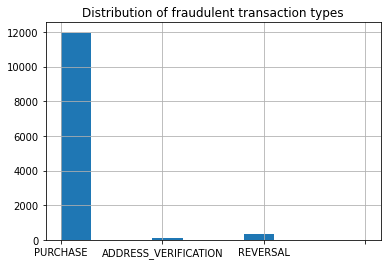

In [38]:
transactions[transactions.isFraud == True].transactionType.hist()
plt.title('Distribution of fraudulent transaction types')
plt.show()

<p> As expected fraudulent transactions are generally purchase ones . Initially we would think that transaction reversals that are marked as fraudulent should probably be cleaned, however we need more business knowledge about what these fraudulent cases mean. For the purpose of the exercise we choose to believe that reversals and address verification can be fraudulent.</p>

In [39]:
transactions[(transactions.isFraud == True) & (transactions.transactionType == 'ADDRESS_VERIFICATION')].head()

,accountNumber,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,...,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
2031,863358589,2500.0,498.33,2016-09-27T13:31:51,0.0,West End Beauty #469474,US,US,05,01,...,2014-02-15,2016-06-23,240,240,6614,ADDRESS_VERIFICATION,2001.67,False,False,True
2108,863358589,2500.0,1056.83,2016-11-24T21:37:19,0.0,West End Beauty #72256,US,US,05,01,...,2014-02-15,2016-06-23,240,240,6614,ADDRESS_VERIFICATION,1443.17,False,False,True
8650,934061435,5000.0,4054.43,2016-01-04T13:16:48,0.0,Dunkin' Donuts #48174,US,US,02,01,...,2014-12-31,2014-12-31,210,217,111,ADDRESS_VERIFICATION,945.57,False,False,True
19731,128258324,2500.0,2417.38,2016-04-03T05:43:45,0.0,Boston Fries,US,US,05,01,...,2013-11-22,2016-02-18,657,657,1718,ADDRESS_VERIFICATION,82.62,False,False,True
23465,561697834,5000.0,3610.36,2016-01-07T18:46:11,0.0,Uber,US,US,05,01,...,2014-07-05,2014-07-05,218,218,7292,ADDRESS_VERIFICATION,1389.64,False,False,True


In [37]:
transactions[(transactions.isFraud == True) & (transactions.transactionType == 'ADDRESS_VERIFICATION')].describe(include = ['O'])

,accountNumber,customerId,transactionDateTime,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType
count,116,116,116,116,116,116,116,116,116,116,116,116,116,116,116,116
unique,66,66,116,64,1,1,6,3,12,85,61,78,68,68,73,1
top,782081187,782081187,2016-09-27T13:31:51,ebay.com,US,US,05,01,online_retail,04/2025,2014-01-15,2016-03-15,363,363,7256,ADDRESS_VERIFICATION
freq,14,14,1,9,116,116,42,94,27,4,14,5,10,10,10,116


Investigating address verification frauds show that most of these frauds happen online, and particularly on ebay. 

In [39]:
transactions['transactionDateTime'] = pd.to_datetime(transactions.transactionDateTime)
transactions['currentExpDate'] = pd.to_datetime(transactions.currentExpDate)
transactions['accountOpenDate'] = pd.to_datetime(transactions.accountOpenDate)
transactions['dateOfLastAddressChange'] = pd.to_datetime(transactions.dateOfLastAddressChange)

In [40]:
transactions.dtypes

accountNumber                       object
customerId                          object
creditLimit                        float64
availableMoney                     float64
transactionDateTime         datetime64[ns]
transactionAmount                  float64
merchantName                        object
acqCountry                          object
merchantCountryCode                 object
posEntryMode                        object
posConditionCode                    object
merchantCategoryCode                object
currentExpDate              datetime64[ns]
accountOpenDate             datetime64[ns]
dateOfLastAddressChange     datetime64[ns]
cardCVV                             object
enteredCVV                          object
cardLast4Digits                     object
transactionType                     object
currentBalance                     float64
cardPresent                           bool
expirationDateKeyInMatch              bool
isFraud                               bool
dtype: obje

How many times is the acqCountry the same as merchantCountryCode? - We assume that acqCountry means where the credit card was acquired/ or the billing address, but more knownledge from the business could help in feature selection.

In [41]:
(transactions.acqCountry != transactions.merchantCountryCode).sum() / transactions.shape[0]

0.004973530036382688

transactions[(transactions.acqCountry != transactions.merchantCountryCode)].isFraud.value_counts() 

In [44]:
(transactions.cardCVV != transactions.enteredCVV).sum()

7015

In [46]:
transactions[(transactions.cardCVV != transactions.enteredCVV)].isFraud.value_counts() 

False    6812
True      203
Name: isFraud, dtype: int64

Both of these can lead to informative features, since from a business perspective fraudsters are likely to enter CVV's that don't match, and also falsify they're address.

Which is the account with the highest number of transactions and how what is the distribution of fraudulent transactions?

In [53]:
transactions.groupby('accountNumber').count()['transactionAmount'][transactions.groupby('accountNumber').count()['transactionAmount'].max() ==  transactions.groupby('accountNumber').count()['transactionAmount']]

accountNumber
380680241    32850
Name: transactionAmount, dtype: int64

In [56]:
transactions[transactions.accountNumber == '380680241'].isFraud.value_counts() / transactions[transactions.accountNumber == '380680241'].isFraud.value_counts().sum()

False    0.976164
True     0.023836
Name: isFraud, dtype: float64

# Q.3 Data Wrangling - Identifying reversals and multi-swipe transactions 

Reversals and multi swipe vary in time, however the things they have in common are accountNumber, transactionAmount and merchantName. Here merchantName has not been preprocessed, since we want to find duplicates of transactions at each physical retail store / instance of a particular merchant.

The algorithm used to compute duplicates: 
1. Pre Sort transactions according to the transactionDateTime
2. REVERSALS:
    for each in unique(accountNumber,transactionAmount and MerchantName):
        if LAG(transactionType) == 'PURCHASE' and transactionType == 'REVERSAL':
            print('Reversal Identified')
3. MULTISWIPE: Multi-swipes are slightly complicated because we need to decide a time frame between consecutive transactions   that occur to be classified as multi-swipe. Thus for the algorithm, we decide a threshold for eg. 2 mins (UPPER LIMIT) between each of the transactions to be classified as multi-swipe. We also assume that the type of the transaction has to be similar in each of the cases.
    for each in unique(accountNumber,transactionAmount,MerchantName,transactionType):
        if LAG(transactionDateTime) - transactionDateTime <= time_threshold:
            print('Duplicate Identified')

Note: This method works since the first transaction is considered normal as described in the question. We also assume that transactionAmount has to be the same for a transaction to be called duplicate. 

In [60]:
transactions = transactions.sort_values(by = 'transactionDateTime',ascending = True)

In [61]:
duplicated = transactions.groupby(['accountNumber','transactionAmount','merchantName']).count()
to_inspect = duplicated[duplicated['creditLimit'] > 1].index

In [62]:
indexed_transactions = transactions.set_index(['accountNumber','transactionAmount','merchantName'])

In [63]:
len(to_inspect.to_frame()['accountNumber'].unique())

4517

<p> 4517 out of 5000 accounts have some kind of duplicate transactions! </p>

## Below we estimate reversed and multi-swipe transaction amounts and numbers

#### In case of multi-swipe the time of the transactions should be really close. Let's analyze the distribution of time differences between these transactions.

#### <u> Scenarios: </u>
1. A credit card transaction could be reversed.
2. A transaction could be multi swiped.
3. A transaction could be reversed and further multi-swiped. 
4. A transaction could be multi-swiped followed by reversal.

The algorithm should work for all these cases.

#### <u> Questions raised during this exercise: </u>

- Do we want to remove any of these data points from the dataset to introduce more balance? 
- How do creditLimit, availableMoney and currentBalance work together in case of these duplicated transactions? Does might affect our data quality going into the model , and we must take care of data cleaning if necessary.

## REVERSALS

In [64]:
indexed_transactions.loc[to_inspect][indexed_transactions.loc[to_inspect]['transactionType'] == 'REVERSAL']

customerId  creditLimit  \
accountNumber transactionAmount merchantName                                   
100088067     22.32             AMC #79863            100088067      50000.0   
100328049     43.74             Lyft                  100328049       5000.0   
              284.97            McDonalds #423357     100328049       5000.0   
100737756     93.67             34th BBQ #436606      100737756        250.0   
              501.29            Best Bistro #262998   100737756        250.0   
...                                                         ...          ...   
999258704     367.13            Uber                  999258704       5000.0   
999283629     96.56             Lyft                  999283629       2500.0   
              150.58            Franks Sandwitch Bar  999283629       2500.0   
              247.40            Delta Airlines        999283629       2500.0   
              407.23            apple.com             999283629       2500.0   

                                                      availableMoney  \
accountNumber transactionAmount merchantName                           
100088067     22.32             AMC #79863                  49811.88   
100328049     43.74             Lyft                         4605.10   
              284.97            McDonalds #423357            3792.09   
100737756     93.67             34th BBQ #436606              119.51   
              501.29            Best Bistro #262998           144.52   
...                                                              ...   
999258704     367.13            Uber                         4246.82   
999283629     96.56             Lyft                         2403.44   
              150.58            Franks Sandwitch Bar         2034.10   
              247.40            Delta Airlines               2500.00   
              407.23            apple.com                    2500.00   

                                                     transactionDateTime  \
accountNumber transactionAmount merchantName                               
100088067     22.32             AMC #79863           2016-11-20 08:00:04   
100328049     43.74             Lyft                 2016-01-15 20:36:18   
              284.97            McDonalds #423357    2016-03-26 17:35:09   
100737756     93.67             34th BBQ #436606     2016-06-06 22:56:52   
              501.29            Best Bistro #262998  2016-08-24 20:21:19   
...                                                                  ...   
999258704     367.13            Uber                 2016-03-16 07:14:17   
999283629     96.56             Lyft                 2016-06-07 18:32:39   
              150.58            Franks Sandwitch Bar 2016-11-19 18:48:08   
              247.40            Delta Airlines       2016-05-01 05:42:19   
              407.23            apple.com            2016-10-03 11:08:21   

                                                     acqCountry  \
accountNumber transactionAmount merchantName                      
100088067     22.32             AMC #79863                   US   
100328049     43.74             Lyft                         US   
              284.97            McDonalds #423357            US   
100737756     93.67             34th BBQ #436606             US   
              501.29            Best Bistro #262998          US   
...                                                         ...   
999258704     367.13            Uber                         US   
999283629     96.56             Lyft                         US   
              150.58            Franks Sandwitch Bar         US   
              247.40            Delta Airlines               US   
              407.23            apple.com                    US   

                                                     merchantCountryCode  \
accountNumber transactionAmount merchantName                               
100088067     22.32             AMC #79863                    

In [65]:
duplicate = indexed_transactions.loc[to_inspect]

In [66]:
duplicate_grouped = duplicate.groupby(level = [0,1,2])

In [67]:
reversed_transactions = duplicate[(duplicate['transactionType'] != duplicate_grouped['transactionType'].shift(1)) 
          & (duplicate_grouped['transactionType'].shift(1).notna()) 
          & (duplicate['transactionType'] == 'REVERSAL')
         ]

In [68]:
reversed_transactions.reset_index().transactionAmount.sum()

2669343.17

In [69]:
reversed_transactions.reset_index().transactionAmount.count()

18347

### REVERSALS - The estimated transaction amount of reversals is 2.669 million dollars and estimated number of reversed transactions that were preceded by purchases: 18347 

Below we have analysis on what percentage of total reversals are caught by our algorithm 

In [71]:
total_reversals = transactions[transactions.transactionType == 'REVERSAL']
total_reversals.set_index(['accountNumber','transactionAmount','merchantName'],inplace = True)

In [72]:
total_reversals.shape

(20303, 20)

In [73]:
reversed_transactions.shape

(18347, 20)

In [74]:
pd.concat([total_reversals,reversed_transactions]).drop_duplicates(keep=False).isFraud.sum()

27

In [75]:
total_reversals.isFraud.sum()

337

In [76]:
reversed_transactions.isFraud.sum()

310

In [78]:
pd.concat([total_reversals,reversed_transactions]).drop_duplicates(keep=False).head()

,,,customerId,creditLimit,availableMoney,transactionDateTime,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
accountNumber,transactionAmount,merchantName,,,,,,,,,,,,,,,,,,,,
208319653,44.15,ebay.com,208319653,15000.0,14934.57,2016-01-01 03:12:54,US,US,02,01,online_retail,2021-05-01,2015-03-17,2015-03-17,548,548,7629,REVERSAL,65.43,False,False,False
652669001,8.91,walmart.com,652669001,2500.0,2488.67,2016-01-01 12:12:01,US,US,02,01,online_retail,2023-08-01,2015-12-30,2015-12-30,442,442,3306,REVERSAL,11.33,False,False,False
246251253,59.52,oldnavy.com,246251253,5000.0,2582.15,2016-01-02 18:41:17,US,US,09,01,online_retail,2026-05-01,2014-10-02,2014-10-02,455,455,6002,REVERSAL,2417.85,False,False,False
429052604,84.79,EZ Putt Putt #551896,429052604,500.0,202.39,2016-01-03 16:14:23,US,US,05,01,entertainment,2027-12-01,2015-08-03,2015-08-03,663,663,4554,REVERSAL,297.61,True,False,False
466941547,61.79,sears.com,466941547,15000.0,14828.75,2016-01-03 23:20:26,US,US,05,08,online_retail,2030-02-01,2015-06-29,2015-06-29,374,374,1637,REVERSAL,171.25,False,False,False


<p> So what are these reversals that are not captured by our algorithm? Are they solo-reversals that were not preceded by any purchases (Which does not make sense and could probably be cleaned if they are not fraudulent.) </p>

In [79]:
temp = transactions.set_index(['accountNumber','merchantName'])
temp.loc['428856030','Hilton Hotels #863711']

/tmp/ipykernel_22852/2477448769.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp.loc['428856030','Hilton Hotels #863711']


customerId  creditLimit  availableMoney  \
accountNumber merchantName                                                    
428856030     Hilton Hotels #863711  428856030        250.0          171.99   
              Hilton Hotels #863711  428856030        250.0          113.29   

                                    transactionDateTime  transactionAmount  \
accountNumber merchantName                                                   
428856030     Hilton Hotels #863711 2016-03-10 04:01:26              61.44   
              Hilton Hotels #863711 2016-03-26 02:12:47              47.22   

                                    acqCountry merchantCountryCode  \
accountNumber merchantName                                           
428856030     Hilton Hotels #863711         US                  US   
              Hilton Hotels #863711         US                  US   

                                    posEntryMode posConditionCode  \
accountNumber merchantName                                          
428856030     Hilton Hotels #863711           09               01   
              Hilton Hotels #863711           09               01   

                                    merchantCategoryCode  ... accountOpenDate  \
accountNumber merchantName                                ...                   
428856030     Hilton Hotels #863711               hotels  ...      2009-08-17   
              Hilton Hotels #863711               hotels  ...      2009-08-17   

                                    dateOfLastAddressChange cardCVV  \
accountNumber merchantName                                            
428856030     Hilton Hotels #863711              2009-08-17     990   
              Hilton Hotels #863711              2009-08-17     990   

                                    enteredCVV cardLast4Digits  \
accountNumber merchantName                                       
428856030     Hilton Hotels #863711        990            7660   
              Hilton Hotels #863711        990            7660   

                                    transactionType currentBalance  \
accountNumber merchantName                                           
428856030     Hilton Hotels #863711        PURCHASE          78.01   
              Hilton Hotels #863711        REVERSAL         136.71   

                                     cardPresent  expirationDateKeyInMatch  \
accountNumber merchantName                                                   
428856030     Hilton Hotels #863711         True                     False   
              Hilton Hotels #863711         True                     False   

                                     isFraud  
accountNumber merchantName                    
428856030     Hilton Hotels #863711    False  
              Hilton Hotels #863711    False  

[2 rows x 21 columns]

In [80]:
temp.loc['205026043','Arbys #384282']

/tmp/ipykernel_22852/43638568.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  temp.loc['205026043','Arbys #384282']


customerId  creditLimit  availableMoney  \
accountNumber merchantName                                            
205026043     Arbys #384282  205026043       5000.0          851.38   
              Arbys #384282  205026043       5000.0          692.68   

                            transactionDateTime  transactionAmount acqCountry  \
accountNumber merchantName                                                      
205026043     Arbys #384282 2016-11-02 22:43:57             158.70         US   
              Arbys #384282 2016-11-02 22:44:38              67.48         US   

                            merchantCountryCode posEntryMode posConditionCode  \
accountNumber merchantName                                                      
205026043     Arbys #384282                  US           09               01   
              Arbys #384282                  US           09               01   

                            merchantCategoryCode  ... accountOpenDate  \
accountNumber merchantName                        ...                   
205026043     Arbys #384282             fastfood  ...      2008-04-15   
              Arbys #384282             fastfood  ...      2008-04-15   

                            dateOfLastAddressChange cardCVV enteredCVV  \
accountNumber merchantName                                               
205026043     Arbys #384282              2008-04-15     198        198   
              Arbys #384282              2008-04-15     198        198   

                            cardLast4Digits transactionType currentBalance  \
accountNumber merchantName                                                   
205026043     Arbys #384282            3931        PURCHASE        4148.62   
              Arbys #384282            3931        REVERSAL        4307.32   

                             cardPresent  expirationDateKeyInMatch  isFraud  
accountNumber merchantName                                                   
205026043     Arbys #384282         True                     False    False  
              Arbys #384282         True                     False    False  

[2 rows x 21 columns]

<p> After inspecting some of these transactions, we find that there are some reversals that are not made by the same amount, but greater or lesser than the purchase amount! This raises a fundamental question - Should we be flagging this transaction as duplicate? The assumed answer is no. We do not need to flag transactions with different values as duplicate. </p>

<p> Analyzing what these it means in relation to the actual dataset. </p>

In [84]:
percent = 2669343.17 / transactions.transactionAmount.sum() * 100
print('%.2f of the total transactionAmounts values are reversals, which seems to be a fair percentage based on the real world.'%percent)

2.48 of the total transactionAmounts values are reversals, which seems to be a fair percentage based on the real world.


### How do these duplicate transactions affect transactions our model? -> For multi-swipe we make sure that we eliminate such that we have only one transaction. While this might not make much of a difference to the model, it's still worth a shot.  

## MULTI-SWIPE

In [85]:
# Additional transactionType that was not present in the reversals algorithm 

duplicated = transactions.groupby(['accountNumber','transactionAmount','merchantName','transactionType']).count()
to_inspect = duplicated[duplicated['creditLimit'] > 1].index

indexed_transactions = transactions.set_index(['accountNumber','transactionAmount','merchantName','transactionType'])
duplicate = indexed_transactions.loc[to_inspect]
duplicate_grouped = duplicate.groupby(level = [0,1,2])

In [86]:
from datetime import timedelta

time_threshold = 5
multi_swiped = duplicate[duplicate_grouped['transactionDateTime'].diff(1) <= timedelta(minutes = 5)]

<p> Thus for a 5 minute threshold there are 7705 transactions that are identified as multi-swipes </p>

In [87]:
multi_swiped.shape

(7705, 19)

In [ ]:
There are 713

In [88]:
(multi_swiped.groupby(level = [0,1,2,3]).count()['creditLimit'] > 1).sum()

713

Calculating the maximum number of multiswipes in one sequence that a customer has made. Here 4 actually means that 5 transactions were made in a sequence. 

In [63]:
multi_swiped.groupby(level = [0,1,2,3]).count()['creditLimit'].max()

4

Thus in order to give an estimate of the number of transactions and the transactionAmount , we must choose an optimal threshold to define multi-swipe. Below are some graphs that help us analyze what a good time threshold could be. 

In [90]:
nr = list()
max_chain = list()
# What happens when there are 2 consecutive transactions and a 3rd transaction after some time? 

for time_threshold in [1,2,5,10,15,20,25,30]:
    multi_swiped = duplicate[duplicate_grouped['transactionDateTime'].diff(1) <= timedelta(minutes = time_threshold)]
    nr.append(multi_swiped.shape[0])
    max_chain.append(multi_swiped.groupby(level = [0,1,2,3]).count()['creditLimit'].max())

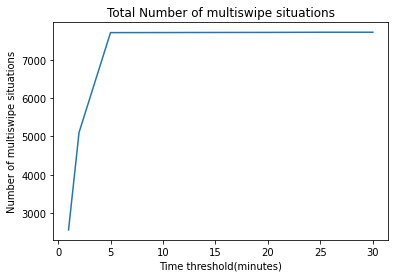

In [93]:
plt.title('Total Number of multiswipe situations')
plt.xlabel('Time threshold(minutes)')
plt.ylabel('Number of multiswipe situations')
plt.plot([1,2,5,10,15,20,25,30],nr)
plt.show()

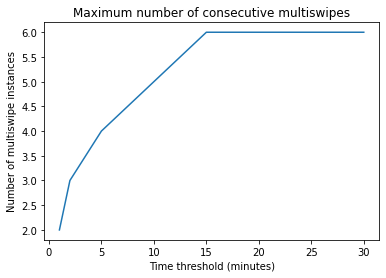

In [94]:
plt.title('Maximum number of consecutive multiswipes')
plt.plot([1,2,5,10,15,20,25,30],max_chain)
plt.xlabel('Time threshold (minutes)')
plt.ylabel('Number of multiswipe instances')
plt.show()

We can see in the first line plot, that the number of multi-swipe situations are capped within 5 minutes, where a customer does not make too many transactions within minutes after that. Thus we choose 5 minutes as our threshold, And provide our estimate of that. (Although in an online situation a customer could be trying to make a purchase until 30 minutes as well, but we leave that out of our estimates for now.)

In [111]:
time_threshold = 5
multi_swiped = duplicate[duplicate_grouped['transactionDateTime'].diff(1) <= timedelta(minutes = 5)]

print('Number of multi-swiped transactions: %d'%multi_swiped.index.shape[0])
print('Total multi-swiped transaction amounts: %f'%multi_swiped.index.to_frame().transactionAmount.sum())

Number of multi-swiped transactions: 7705
Total multi-swiped transaction amounts: 1104075.960000


### MULTI-SWIPES - The estimated transaction amount of reversals is 1.104 million dollars and estimated number of reversed transactions that were preceded by purchases: 7705 

What percentage of multi-swiped / reversed transactions are fraudulent?

In [115]:
reversed_transactions.isFraud.value_counts() + multi_swiped.isFraud.value_counts()

False    25611
True       441
Name: isFraud, dtype: int64

### How do these vary with Fraud, Does it make sense to remove these duplicates? 

These multi-swiped / reversals transactions can be fraudulent and thus it's hard to remove these from the dataset, since each fraudulent case is important, thus this should not be excluded from our dataset.

# Q.4 Modeling 

#### Before we get into modeling, we derive the correlation of every feature to the target in the current dataset, that will potentially help our Feature Engineering and selection. By this we aim to get a sense of how much each feature contributes to the target on it's own.

In [117]:
transactions.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud'],
      dtype='object')

In [118]:
accountNumber = pd.crosstab(transactions.accountNumber,transactions.isFraud,margins = True,margins_name = 'total',normalize = True)

In [119]:
accountNumber.sort_values(by = True,axis = 0, ascending = False).head(20)

isFraud,False,True,total
accountNumber,,,
total,0.984210,0.015790,1.000000
380680241,0.040779,0.000996,0.041775
782081187,0.002706,0.000390,0.003097
246251253,0.012582,0.000354,0.012936
700725639,0.003867,0.000346,0.004213
472288969,0.001938,0.000338,0.002276
208319653,0.006389,0.000268,0.006657
419709514,0.007278,0.000263,0.007541
369308035,0.009020,0.000173,0.009193


It is worthy to note that accountNumber 380680241 has the highest number of Fraudulent transactions. 
It is hard to say that it is the most important in predicting fraud, since this account also comprises of 4% of the entire transaction population. A more informative feature would be percentage of fraud to the actual number of transactions that have been done by the customer, weighted by the number of card transactions he actually does. If target/mean encoding is used, there is a high chance that the model learns a rule where if the accountNumber is the above, there is a high probabality of Fraud, thus not weighing in other factors. Hence we must explore some variant of of mean / frequency encoding could be good for this feature.

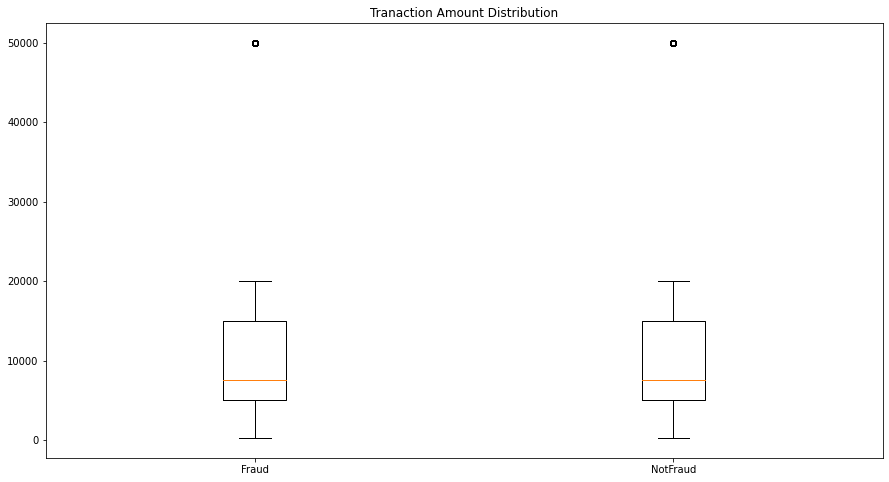

In [120]:
fig, ax = plt.subplots()
fig.set_size_inches((15,8))
data = {'Fraud':transactions.creditLimit[transactions.isFraud == True], 'NotFraud':transactions.creditLimit[transactions.isFraud == False]}
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
plt.title('Tranaction Amount Distribution')
plt.show()

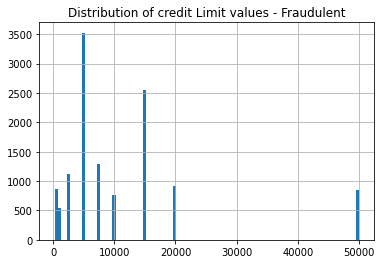

In [122]:
transactions.creditLimit[transactions.isFraud == True].hist(bins = 100)
plt.title('Distribution of credit Limit values - Fraudulent')
plt.show()

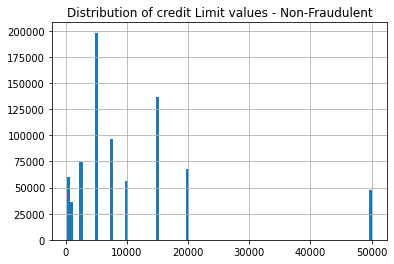

In [123]:
transactions.creditLimit[transactions.isFraud == False].hist(bins = 100)
plt.title('Distribution of credit Limit values - Non-Fraudulent')
plt.show()

<p> Hard to say anything about creditLimit, since both are pretty evenly distributed, this might not be the most informative feature on it's own. However, percentage of creditLimit with transactionAmount could prove to be a useful feature, may smaller transactions are more likely to be fraudulent, or vice versa, so this is a good candidate for feature elimination / engineering. It could be a useful feature when used along with non-linear models. </p>

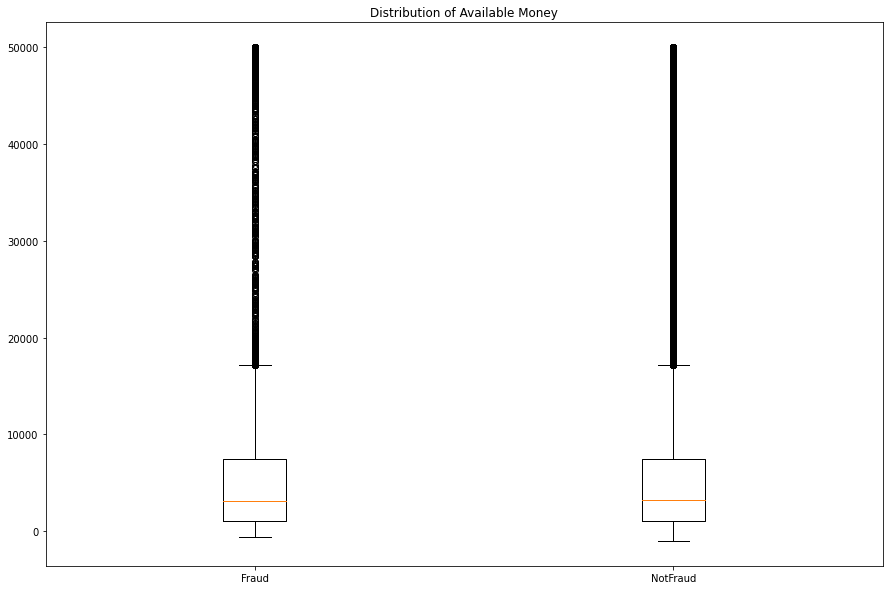

In [124]:
fig, ax = plt.subplots()
fig.set_size_inches((15,10))
data = {'Fraud':transactions.availableMoney[transactions.isFraud == True], 'NotFraud':transactions.availableMoney[transactions.isFraud == False]}
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
plt.title('Distribution of Available Money')
plt.show()

### Similar thought with availableMoney, let's see if a availableMoney as a function of transactionAmount is a better method.

All transactions were made in 2016

In [125]:
transactions.transactionDateTime.apply(lambda x: x.year).unique()

array([2016])

<AxesSubplot:>

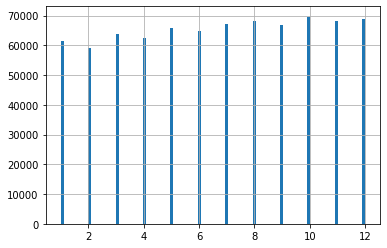

In [126]:
transactions.transactionDateTime.apply(lambda x: x.month).hist(bins = 100)

<AxesSubplot:>

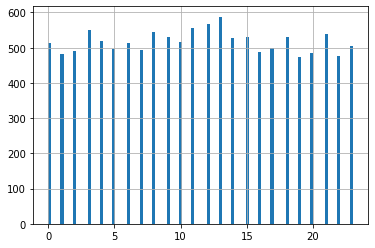

In [127]:
transactions[transactions.isFraud == True].transactionDateTime.apply(lambda x: x.hour).hist(bins = 100)

<p> While there is not much difference in the transactionTiming (which is something we would have expected), it is clear that the hour of the transaction varies more in the Fraudelent cases. We would expect fraudulent cases to be towards the night, but it looks like frauds take place in the day at around 1pm. </p>

<AxesSubplot:>

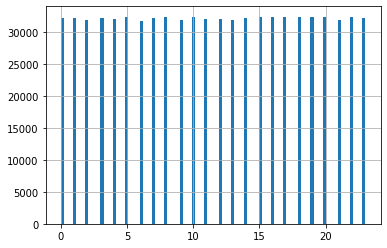

In [128]:
transactions[transactions.isFraud == False].transactionDateTime.apply(lambda x: x.hour).hist(bins = 100)

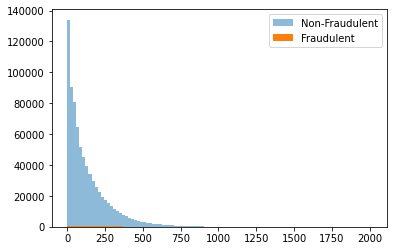

In [129]:
bins = 100
plt.hist(transactions[transactions.isFraud == False].transactionAmount, bins, alpha=0.5, label='Non-Fraudulent')
plt.hist(transactions[transactions.isFraud == True].transactionAmount,bins, alpha=1, label='Fraudulent')
plt.legend(loc='upper right')
plt.show()

In [130]:
transactions[transactions.isFraud == True].transactionAmount.max()

1608.35

In [131]:
transactions[transactions.isFraud == False].transactionAmount.max()

2011.54

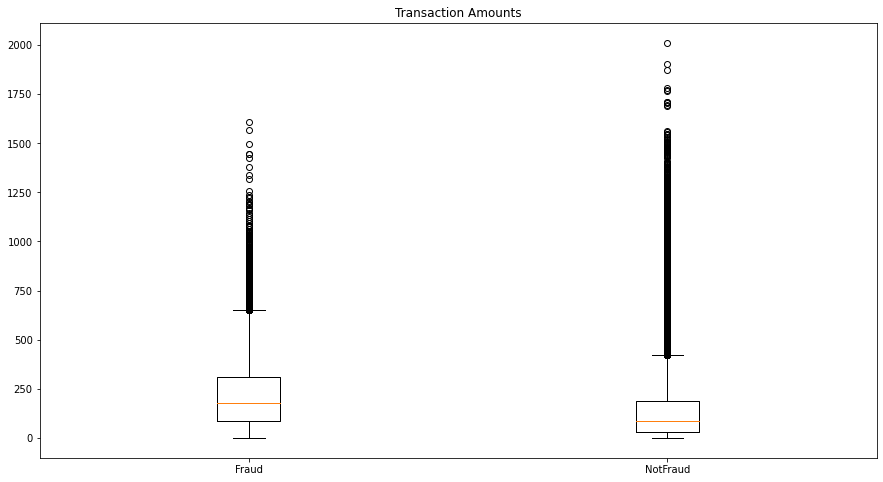

In [133]:
fig, ax = plt.subplots()
fig.set_size_inches((15,8))
data = {'Fraud':transactions.transactionAmount[transactions.isFraud == True], 'NotFraud':transactions.transactionAmount[transactions.isFraud == False]}
ax.boxplot(data.values())
ax.set_xticklabels(data.keys())
plt.title('Transaction Amounts')
plt.show()

<p> Thus it is important to not that removing outliers in our transaction dataset based on amounts might help us build a robust model, if at all transactionAmount turns out to be an important feature.
This could be part of our sampling strategy where we sample from the dataset transaction amounts are less than a certain amount </p>

In [134]:
pd.crosstab(transactions.acqCountry,transactions.isFraud,normalize = True,margins = True,margins_name = 'Total')

isFraud,False,True,Total
acqCountry,,,
,0.005612,0.000189,0.005801
CAN,0.003013,0.000070,0.003083
MEX,0.003899,0.000081,0.003980
PR,0.001922,0.000034,0.001956
US,0.969765,0.015415,0.985180
Total,0.984210,0.015790,1.000000


In [135]:
pd.crosstab(transactions.acqCountry,transactions.isFraud,normalize = 'columns',margins = True,margins_name = 'Total')

isFraud,False,True,Total
acqCountry,,,
,0.005702,0.012000,0.005801
CAN,0.003061,0.004429,0.003083
MEX,0.003962,0.005154,0.003980
PR,0.001952,0.002174,0.001956
US,0.985323,0.976242,0.985180


<p> Most of the transactions i.e 98.5 % of them are from US, while 97.6% of the True transactions are also from US. This gives us the sense that the feature can be important in its original state and we keep it as it is, since the distribution persists. </p> 

In [136]:
pd.crosstab(transactions.acqCountry,transactions.isFraud,normalize = 'index',margins = True,margins_name = 'total')

isFraud,False,True
acqCountry,,
,0.967339,0.032661
CAN,0.977310,0.022690
MEX,0.979553,0.020447
PR,0.982445,0.017555
US,0.984353,0.015647
total,0.984210,0.015790


<p> Note that the first row is actually a null value. Crosstab analysis helps us understand how when country is not specified, there is a 3.2 % chance that the transaction is Fraudulent, compared to the usual 1-2% in other countries. Keeping this feature is probably a good idea.
</p>

In [137]:
merchant_names = pd.crosstab(transactions.merchantName,transactions.isFraud,normalize = 'index')
merchant_names.sort_values(by = True,axis = 0,ascending = False).head(10)

isFraud,False,True
merchantName,,
In-N-Out #949129,0.887640,0.112360
American Airlines,0.906021,0.093979
In-N-Out #863086,0.906250,0.093750
In-N-Out #463194,0.916667,0.083333
In-N-Out #422833,0.918182,0.081818
In-N-Out #567597,0.921348,0.078652
Walgreens #475572,0.928571,0.071429
In-N-Out #17755,0.931373,0.068627
Fresh Flowers,0.933645,0.066355


<p> From the data, it is very clearly visible that In-N-Out is a one of the top features where fraud takes place, in terms of percentage of it's own transactions. The number of retail locations a merchant has can also contribute to how fraudulent a transaction can be.
</p>

In [138]:
merchant_names = pd.crosstab(transactions.merchantName,transactions.isFraud,normalize = True)
merchant_names.sort_values(by = True,axis = 0,ascending = False).head(20)

isFraud,False,True
merchantName,,
Lyft,0.031491,0.000966
ebay.com,0.020605,0.000813
Fresh Flowers,0.009895,0.000703
Uber,0.031920,0.000651
walmart.com,0.020890,0.000567
cheapfast.com,0.020876,0.000562
sears.com,0.020770,0.000537
oldnavy.com,0.021098,0.000510
staples.com,0.021086,0.000507


<p> Most of the credit card frauds take place at lyft. However, since there are multiple locations of each of the other retailers like InAndOut, we might need some text preprocessing to get a true idea of which merchant's are troublesome. </p>

In [139]:
len(transactions.merchantName.unique())

2490

<p> Thus by applying this transformation, our contingency tables will change. </p>

In [140]:
transactions.merchantName = transactions.merchantName.apply(lambda x: re.sub('(#[0-9]+)','',x).strip())

In [141]:
merchant_names = pd.crosstab(transactions.merchantName,transactions.isFraud,normalize = 'index')
merchant_names.sort_values(by = True,axis = 0,ascending = False).head(10)

isFraud,False,True
merchantName,,
American Airlines,0.906021,0.093979
Fresh Flowers,0.933645,0.066355
ethanallen.com,0.951020,0.048980
Convenient Auto Services,0.957467,0.042533
Rove Concepts,0.957627,0.042373
In-N-Out,0.957805,0.042195
Dinosaur Restaurant,0.959330,0.040670
ebay.com,0.962059,0.037941
Best Pub,0.965978,0.034022


<p> It's interesting to see how American Airlines transactions are fraudulent at least 1 in 10 times! </p>

In [142]:
merchant_names = pd.crosstab(transactions.merchantName,transactions.isFraud,normalize = True)
merchant_names.sort_values(by = True,axis = 0,ascending = False).head(20)

isFraud,False,True
merchantName,,
Lyft,0.031491,0.000966
ebay.com,0.020605,0.000813
Fresh Flowers,0.009895,0.000703
Uber,0.031920,0.000651
EZ Putt Putt,0.038433,0.000623
walmart.com,0.020890,0.000567
cheapfast.com,0.020876,0.000562
sears.com,0.020770,0.000537
oldnavy.com,0.021098,0.000510


<p> The merchantCountry code and acqCountry code matches 99.5% of the time on the entire dataset, and similarly on the test dataset. Thus only for a very few transactions this feature may be adding value. This is another good candidate for feature removal/engineering </p>

In [145]:
(transactions.acqCountry == transactions.merchantCountryCode).sum() / transactions.shape[0]

0.9950264699636173

In [146]:
(transactions[transactions.isFraud == True].acqCountry == transactions[transactions.isFraud == True].merchantCountryCode).sum() / transactions[transactions.isFraud == True].shape[0]

0.9946041717000886

In [147]:
merchant_codes = pd.crosstab(transactions.merchantCategoryCode,transactions.isFraud,normalize = True)
merchant_codes.sort_values(by = True,axis = 0,ascending = False).head(5)

isFraud,False,True
merchantCategoryCode,,
online_retail,0.250798,0.006280
online_gifts,0.082191,0.002042
rideshare,0.063411,0.001618
fastfood,0.141238,0.001366
food,0.094709,0.001289


In [148]:
merchant_codes = pd.crosstab(transactions.merchantCategoryCode,transactions.isFraud,normalize = 'index')
merchant_codes.sort_values(by = True,axis = 0,ascending = False).head(5)

isFraud,False,True
merchantCategoryCode,,
airline,0.965352,0.034648
rideshare,0.975125,0.024875
online_retail,0.975573,0.024427
online_gifts,0.975754,0.024246
furniture,0.986141,0.013859


<p> As we observed above, airline (American) do have a high rate of being fraud. Also, online retail holds the highest share of Fraudulent transactions</p>

<p> The values of card CVV in itself might not be contributing to fraud, It is strange to see that there are 899 CVV's across 5000 accounts, this is probably because CVV's can be duplicate but card numbers need not. Intuitively, this seems to be a good candidate for feature elimination, but enteredCVV might have stronger patterns. </p>

In [149]:
len(transactions.cardCVV.unique())

899

In [150]:
pd.crosstab((transactions.enteredCVV != transactions.cardCVV),transactions.isFraud,normalize = True)

isFraud,False,True
row_0,,
False,0.975547,0.015532
True,0.008663,0.000258


<p>This shows that the difference in enteredCVV and cardCVV may not be as powerful a feature on it's own, given, that it points out isFraud only 0.2% of the times.However, it is possible that a particular fraudster has a pattern of putting in CVVs from different accounts, and we must rely on good non-linera models to extract information out of this feature. </p>

In [153]:
fraud_CVVs = pd.crosstab(transactions.enteredCVV ,transactions.isFraud,normalize = 'columns').sort_values(by = True,axis = 0,ascending = False)

<p> Which accounts do the top entered CVV's for fraudulent transactions come from? </p>

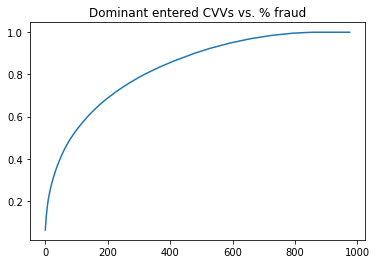

In [154]:
plt.plot(range(len(fraud_CVVs)), fraud_CVVs.cumsum().iloc[:,1])
plt.title('Dominant entered CVVs vs. % fraud')
plt.show()

<p> This gives us a sense of whether the frauds are dominated by some particular CVV's. The initial 50-60% of the population does rely on some 20% of the most fraudulent enteredCVVs. A target encoding scheme could work pretty well with this feature. </p>

In [155]:
pd.crosstab(transactions.enteredCVV.apply(lambda x: len(set(str(x)))),transactions.isFraud,normalize = True)

isFraud,False,True
enteredCVV,,
1,0.007957,0.000064
2,0.261540,0.004246
3,0.714713,0.011481


<p> This feature doesn't really tell anything </p>

In [156]:
len(transactions.cardLast4Digits.unique())

5246

<p> Given that there are 5246 credit cards that are distributed amongst 5000 account holders, the individual credit card numbers in themselves probably do not hold much value. 
However, we can encode this information in a smarter way by encoding the number of credit cards an account holder as, and checking it's distribution </p>

In [157]:
transactions.isFraud.sum()

12417

In [158]:
numberOfCards = transactions.groupby('accountNumber')['cardLast4Digits'].nunique().astype(str)

In [159]:
numberOfCards.name = 'numberOfCards'

In [160]:
transactions = transactions.set_index('accountNumber').join(numberOfCards).reset_index()

In [161]:
pd.crosstab(transactions.numberOfCards,transactions.isFraud,normalize = True)

isFraud,False,True
numberOfCards,,
1,0.608176,0.009604
2,0.296624,0.005138
3,0.069258,0.000916
4,0.009178,0.000113
5,0.000913,0.000020
6,0.000061,0.000000


<p> This distribution of people with more number of cards are more likely to be fraudulent is probably wrong. The more cards people have the more likely it is that they are not fraudulent. But we still keep our hopes that the model will find patterns we can't comprehend, and keep this feature.</p>

<p> Time to expiry can say a lot about the time the card was prescribed to, older customers are less likely to commit fraud and newer customers are more likely</p>

In [162]:
(transactions.currentExpDate - transactions.transactionDateTime).min()

Timedelta('1065 days 08:21:19')

In [163]:
(transactions.currentExpDate - transactions.transactionDateTime).max()

Timedelta('6421 days 12:34:47')

In [164]:
days_to_expiry = (transactions.currentExpDate - transactions.transactionDateTime).apply(lambda x: x.days)

<p> An attempt to use logistic regression failed for this purpose, due to class imbalance. We could rather check the distribution </p>

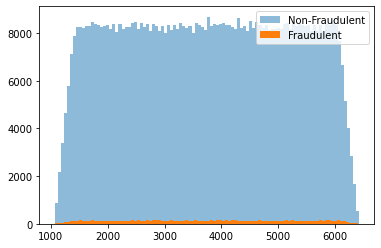

In [165]:
bins = 100
plt.hist(days_to_expiry[transactions.isFraud == False], bins, alpha=0.5, label='Non-Fraudulent')
plt.hist(days_to_expiry[transactions.isFraud == True],bins, alpha=1, label='Fraudulent')
plt.legend(loc='upper right')
plt.show()

Again it has is difficult to conclude that this is likely to be one of the most important features, however, it is worth considering this feature from a business sense.

In [166]:
days_from_last_address = ( transactions.transactionDateTime - transactions.dateOfLastAddressChange).apply(lambda x: x.days)
days_from_account_open = ( transactions.transactionDateTime - transactions.accountOpenDate).apply(lambda x: x.days)

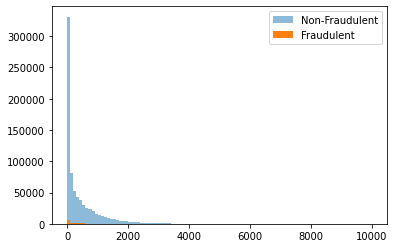

In [167]:
bins = 100
plt.hist(days_from_last_address[transactions.isFraud == False], bins, alpha=0.5, label='Non-Fraudulent')
plt.hist(days_from_last_address[transactions.isFraud == True],bins, alpha=1, label='Fraudulent')
plt.legend(loc='upper right')
plt.show()

<p> It is evident that newer address changes are quite likely to be fraudulent </p>

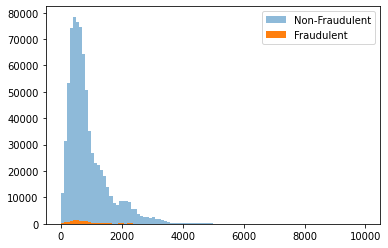

In [168]:
bins = 100
plt.hist(days_from_account_open[transactions.isFraud == False], bins, alpha=0.5, label='Non-Fraudulent')
plt.hist(days_from_account_open[transactions.isFraud == True],bins, alpha=1, label='Fraudulent')
plt.legend(loc='upper right')
plt.show()

We see similar behaviour as compared to address change.

In [169]:
pd.crosstab(transactions.posEntryMode, transactions.isFraud)

isFraud,False,True
posEntryMode,,
,3785,269
02,192513,3421
05,312579,2456
09,230822,5659
80,15043,240
90,19204,372


In [170]:
pd.crosstab(transactions.posConditionCode, transactions.isFraud)

isFraud,False,True
posConditionCode,,
,387,22
01,618557,10230
08,147698,1936
99,7304,229


<p> Both of these features are likely hold value in the modeling stage </p>

In [171]:
transactions.isna().sum().sum()

0

### Feature Engineering and Selection

In [172]:
transactions.columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionDateTime', 'transactionAmount', 'merchantName',
       'acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'transactionType', 'currentBalance', 'cardPresent',
       'expirationDateKeyInMatch', 'isFraud', 'numberOfCards'],
      dtype='object')

In [173]:
transactions['correctCVV'] = (transactions.cardCVV == transactions.enteredCVV)

In [174]:
transactions.drop('cardCVV',inplace = True,axis = 1)

In [175]:
transactions.isna().sum().sum()

0

In [176]:
transactions['withinCountry'] = transactions.merchantCountryCode == transactions.acqCountry
transactions.drop('merchantCountryCode',inplace = True,axis = 1)

### Numeric features

In [177]:
transactions['percent_transaction_credit'] = transactions.transactionAmount / transactions.creditLimit
transactions['percent_available_credit'] = transactions.availableMoney / transactions.creditLimit
# Somebody's bill can cause a credit card default. 
transactions['percent_balance_credit'] = transactions.currentBalance / transactions.creditLimit

#transactions['percent_balance_transactions'] = transactions.transactionAmount / transactions.currentBalance -> Results in nan values

#transactions.drop(['creditLimit'],inplace = True,axis = 1)
# We do not drop availableMoney, since if hackers know money is available, there might be reason for fraud.

### Temporal features

In [178]:
transactions['transaction_month'] = transactions.transactionDateTime.apply(lambda x:x.month)
transactions['transaction_day'] = transactions.transactionDateTime.apply(lambda x:x.day)
transactions['transaction_hour'] = transactions.transactionDateTime.apply(lambda x:x.hour)

transactions['a_open_year'] = transactions.accountOpenDate.apply(lambda x:x.year)
transactions['a_open_month'] = transactions.accountOpenDate.apply(lambda x:x.month)
transactions['a_open_day'] = transactions.accountOpenDate.apply(lambda x:x.day)
transactions['a_open_hour'] = transactions.accountOpenDate.apply(lambda x:x.hour)

days_to_expiry = (transactions.currentExpDate - transactions.transactionDateTime).apply(lambda x: x.days)
days_from_last_address = ( transactions.transactionDateTime - transactions.dateOfLastAddressChange).apply(lambda x: x.days)
days_from_account_open = ( transactions.transactionDateTime - transactions.accountOpenDate).apply(lambda x: x.days)

transactions.drop(['dateOfLastAddressChange','accountOpenDate','currentExpDate'],inplace = True,axis = 1)

In [179]:
transactions.drop(['cardLast4Digits'],inplace = True,axis = 1)

In [180]:
transactions.drop('transactionDateTime',axis = 1,inplace = True)

#### Current Encoding techniques
    accountNumber - Count Encoding
    enteredCVV- Target Encoding
    merchantName - targetEncoding
    merchantCategoryCode - targetEncoding
    acqCountry - OneHot
    posEntryMode - OneHot
    posConditionCode - OneHot
    transactionType - OneHot

In [181]:
transactions['numberOfCards'] = transactions.numberOfCards.astype('int')

In [182]:
transactions['acqCountry'] = transactions.acqCountry.apply(lambda x: 'NA' if x == '' else x)
transactions['posEntryMode'] = transactions.posEntryMode.apply(lambda x: 'NA' if x == '' else x)
transactions['posConditionCode'] = transactions.posConditionCode.apply(lambda x: 'NA' if x == '' else x)
transactions['transactionType'] = transactions.transactionType.apply(lambda x: 'NA' if x == '' else x)

In [184]:
Y = transactions['isFraud']
X = transactions.drop('isFraud',axis = 1)

encoding_transformer = ColumnTransformer([
    ('one_hot',OneHotEncoder(),['acqCountry','posEntryMode','posConditionCode','transactionType']),
    ('count',CountEncoder(),['accountNumber']), # Idea is to rank the accountNumbers
    ('target',TargetEncoder(),['merchantCategoryCode','merchantName','enteredCVV'])
],remainder = 'passthrough',verbose = True,verbose_feature_names_out = True)

X = encoding_transformer.fit_transform(X,Y)

[ColumnTransformer] ....... (1 of 4) Processing one_hot, total=   2.6s
[ColumnTransformer] ......... (2 of 4) Processing count, total=   0.8s
[ColumnTransformer] ........ (3 of 4) Processing target, total=   2.2s
[ColumnTransformer] ..... (4 of 4) Processing remainder, total=   0.0s


## Sampling Strategy 

Our sampling strategy needs to be representative of the true population , and yet well distributed enough across multiple class labels. 
Ideally we could make sure to use unsupervised techniques to learn clusters of transactions and sample in a stratified manner from those clusters, but in interest of time we use a sampling technique 
that uses all the transactions that are fraudulent, and undersamples the non-fraudulent transactions. The most representative strategy would be randomized undersampling. We could use other undersampling techniques, like Edited Nearest neighbor, however that might take some more time to execute.

Experiments were done where we also over sample using a randomOverSampling technique that increases the existence of true labels until it matches 0.05 of the non-fraudulent population. 
We attemped to use only undersampling (0.5), but thought that would be oversimplifying the problem by reducing the sample size too much, and to keep it realistic, we introduced the oversampling component and work with that. However, results showed an extremely good f1-score of 0.94 and the optimal classification threshold turned out to be close to 0.5, which was dubious (This is probably because the Random oversampling resampled similar kind's of instances way too many times.), but was also promising to see that strong classification boundary likely exists in the dataset.

 For the purpose of our fraud detection, recall is specifically important. From a business sense, having higher recall might be of more importance then that of higher precision.

In [284]:
under = RandomUnderSampler(0.3) # Minority class constitutes what percent of population

pipeline = Pipeline(steps=[('u', under)])

x,y = pipeline.fit_resample(X,Y)

/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.3 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [285]:
from sklearn.metrics import f1_score,recall_score,precision_score,roc_auc_score,roc_curve
from sklearn.model_selection import train_test_split

model_pipeline = Pipeline([('sc',StandardScaler()),
                           ('rf',RandomForestClassifier(n_jobs = -1))])

train_x,test_x, train_y,test_y = train_test_split(x,y,stratify = y,random_state = 42)

model_pipeline.fit(train_x,train_y)

print('Model Accuracy %f'%model_pipeline.score(test_x,test_y))
print('Model f1_score %f'%f1_score(model_pipeline.predict(test_x),test_y))
print('Model precision_score %f'%recall_score(model_pipeline.predict(test_x),test_y))
print('Model recall_score %f'%precision_score(model_pipeline.predict(test_x),test_y))
print('Model roc auc score %f'%roc_auc_score(model_pipeline.predict(test_x),test_y))

Model Accuracy 0.835787
Model f1_score 0.558465
Model precision_score 0.735650
Model recall_score 0.450064
Model roc auc score 0.793948


AUC score suggests decent predictive power

In [286]:
def predict_threshold(data,threshold = 0.5):
    # Data is expected to be probabilities.
    return (data[:,1] >= threshold).astype(int)

In [287]:
thresholds = np.linspace(0,1,99)
fs = []
recalls = []
precisions = []

for t in thresholds:
    preds = predict_threshold(model_pipeline.predict_proba(test_x),t)
    fs.append(f1_score(test_y,preds))
    recalls.append(recall_score(test_y,preds))
    precisions.append(precision_score(test_y,preds))

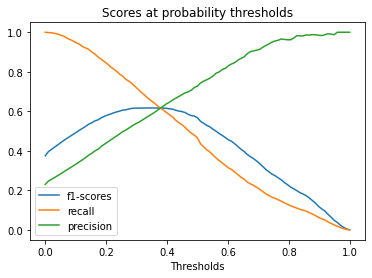

In [289]:
plt.title('Scores at probability thresholds')
plt.plot(thresholds,fs,label = 'f1-scores')
plt.plot(thresholds,recalls,label = 'recall')
plt.plot(thresholds,precisions,label = 'precision')
plt.xlabel('Thresholds')
plt.legend(loc = 'best')
plt.show()

From this plot it is evident that a threshold of around 0.4 for decision making, makes best sense ,with a recall, precision and f1-score of around 0.6

Let's look at some feature importances

In [290]:
model = model_pipeline[1]

/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


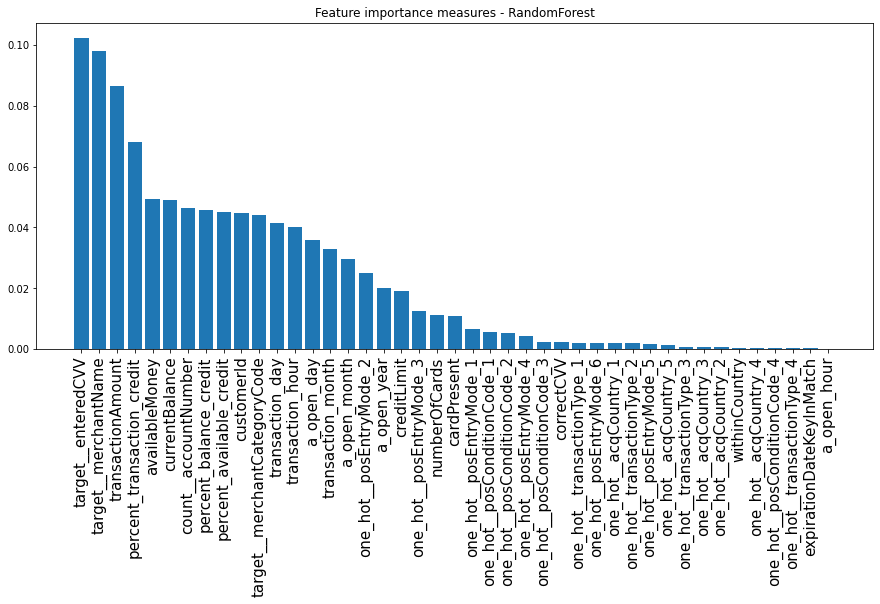

In [291]:
indices = np.argsort(model.feature_importances_)[::-1]
features = encoding_transformer.get_feature_names()
features = [features[i] for i in indices]
plt.figure(figsize = (15,6))
plt.title('Feature importance measures - RandomForest')
plt.bar(features,model.feature_importances_[indices])
plt.xticks(features,rotation = 90,fontsize = 15)
plt.show()

It is interesting to see  merchantName, enteredCVV, transactionAmount and accountNumber are all important features, which also makes business sense.The feature importance chart shows that enteredCVV is an important feature, meaning there are strong patterns present in the CVV entered by the fraudster. Now, this can also be a result of the target encoding scheme that we used, since target encoding assigns higher value to categories present the most number of times. Tests should be done so as to make sure this model generalizes well. 
It's also fascinating to see the percentage of transaction to creditLimit be one of the top features, implying that the % of transactionAmount / creditLimit has something to do with Fraud.

After the initial test with RandomForests, let's have a look at models that might fit non-linear patterns better, and report their f1_scores , and see if there's any considerable difference in any of them , if not, we can move to focussing on building an ensemble, hyperparameter tuning and building better features. 

In [292]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline

other_classifiers = {'rf':RandomForestClassifier(n_jobs = -1),'knn':KNeighborsClassifier(),
                     'gbm':GradientBoostingClassifier(),'nn':MLPClassifier(early_stopping = True)}
fitted = {}

for c in other_classifiers.keys():
    classifier = other_classifiers[c]
    pip = make_pipeline(StandardScaler(),classifier)
    pip.fit(train_x,train_y)
    fitted[c] = pip

In [293]:
fitted

{'rf': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('randomforestclassifier', RandomForestClassifier(n_jobs=-1))]),
 'knn': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('kneighborsclassifier', KNeighborsClassifier())]),
 'gbm': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('gradientboostingclassifier', GradientBoostingClassifier())]),
 'nn': Pipeline(steps=[('standardscaler', StandardScaler()),
                 ('mlpclassifier', MLPClassifier(early_stopping=True))])}

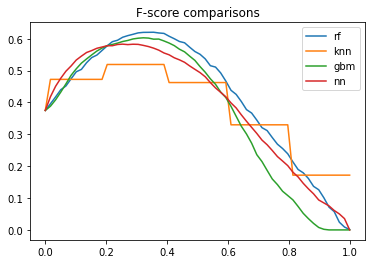

In [294]:
aucs = {}

plt.title('F-score comparisons')

for pip in fitted.keys():
    pipeline = fitted[pip]
    fs = []
    for t in np.linspace(0,1,60):
        preds = predict_threshold(pipeline.predict_proba(test_x),t)
        fs.append(f1_score(test_y,preds))
    plt.plot(np.linspace(0,1,60),fs,label = pip)
    aucs[pip] = roc_curve(test_y,pipeline.predict(test_x))
plt.legend(loc = 'best')
plt.show()

The X-axis is the probability threshold and the Y-axis is the f-score.

The graph shows that all 4 classifiers have similar behaviors on thresholds, and none of them trumps the other by a large margin, however Random Forests are clearly ahead in this one time experiment.

In interest of time we leave it to one experiment, however it should ideally be an averaged score across multiple stratified datasets.

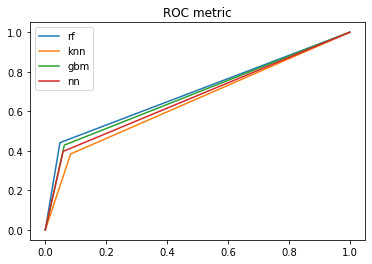

In [295]:
plt.title('ROC metric')
for each in aucs.keys():
    plt.plot(aucs[each][0],aucs[each][1],label = each)
plt.legend(loc = 'best')
plt.show()

The model performance in itself is clearly poor, with a sudden decline in True positive rate, and there is need for better features and a stronger decision boundry, before we get into fine-tuning the model and building ensemble. An attempt at training ensembles with SVMs was made,however the training time was too long, considering the dimensionality and length of the dataset. Hence, we refrain from using SVM's since the training time needed for such datasets is vast, even though SVM classifiers are well suited for this classification task, since the interactions between features need to be captured well. 

### Oversampling + Undersampling, for better decision boundaries

In [296]:
# First Oversample to amplify the importance of fraudulent instances in the dataset. 
# We refrain from using SMOTE since SMOTE creates artificial distributions with 
# EditedNearestNeighbor undersampler is extremely time consuming on 700k data points.

over = RandomOverSampler(0.05) 
under = RandomUnderSampler(0.5)

pipeline = Pipeline(steps=[('o',over),('u', under)])

x,y = pipeline.fit_resample(X,Y)

/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.05 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(
/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/imblearn/utils/_validation.py:586: FutureWarning: Pass sampling_strategy=0.5 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  warnings.warn(


In [297]:
from sklearn.model_selection import RandomizedSearchCV

# Ideally we should be performing the model comparison experiments again, 
# since the underlying data distribution has changed, 
# but results from RandomForests were pretty satisfactory and explainable , so we stick to RandomForests.

train_x,test_x, train_y,test_y = train_test_split(x,y,stratify = y,random_state = 42)

n_estimators = [100, 300, 500, 800, 1200]
max_depth = [5, 8, 15, 25, 30]
min_samples_split = [2, 5, 10, 15, 100]
min_samples_leaf = [1, 2, 5, 10] 

hyperF = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf)

grid = RandomizedSearchCV(RandomForestClassifier(), hyperF, cv = 3, verbose = 1, scoring = 'recall',
                      n_jobs = -1)

In [298]:
grid.fit(train_x,train_y)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 8, 15, 25, 30],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [100, 300, 500, 800,
                                                         1200]},
                   scoring='recall', verbose=1)

In [299]:
grid.best_estimator_

RandomForestClassifier(max_depth=25, min_samples_split=5, n_estimators=500)

In [300]:
grid.best_score_

0.8686557377749785

#### This sampling strategy has interesetingly gotten us the best recall of 0.86

### Reporting Final K-fold stratified dataset scores for the best estimator...

In [301]:
from sklearn.model_selection import StratifiedKFold

best_model = grid.best_estimator_

average_fscore = []
average_recall = []

skf = StratifiedKFold(n_splits= 3) # We expect the data to maintain it's distribution in train and test.
for (train_index,test_index) in skf.split(x,y):
    best_model.fit(x[train_index],y[train_index])
    preds = best_model.predict(x[test_index])
    
    average_fscore.append(f1_score(y[test_index],preds))
    average_recall.append(recall_score(y[test_index],preds))
    
print('Final Scores for model based on oversampling %.2f %.2f'%(np.mean(average_fscore),np.mean(average_recall)))

Final Scores for model based on oversampling 0.93 0.96


### Final Scores : F1-score - 0.93 Recall score 0.96

This opens up possibility for assessing multiple classifiers, like SVM's / KNN's / Neural Networks that require some scaling. In the next step we will aim at evaluating different classifiers, before building a final ensemble.

In [137]:
over = RandomOverSampler(sampling_strategy = 0.1)
under = RandomUnderSampler(sampling_strategy = 0.3)

In [157]:
classifiers = [RandomForestClassifier(),KNeighborsClassifier(),GradientBoostingClassifier(),SVC()]

In [158]:
scores = [evaluate_classifier((X,Y),classifier) for classifier in classifiers]

Time to evaluation 112.80
Time to evaluation 644.47
Time to evaluation 290.57
Time to evaluation 36657.32


In [159]:
scores

[0.9997095590899482,
 0.9696877286787469,
 0.8454884288802387,
 0.8523424490907141]

Below we build a Final stacking classifier, Ideally we would have included SVC/Neural networks in this since they are exceptional in identifying non-linear patterns, but due to the training time that SVCs take we stick to bagging boosting and linear model ensembles

In [172]:
estimators = [
     ('rf', RandomForestClassifier(n_jobs = -1)),
     ('gbf', GradientBoostingClassifier()),
    ('knn', KNeighborsClassifier())
 ]

clf = StackingClassifier(
     estimators=estimators, final_estimator=LogisticRegression() , n_jobs = -1
 )

thresholds = np.linspace(0,1,99)
fs = []

for t in thresholds:
    fs.append(fit_and_fetch(clf,(X,Y),3,t))
    
plt.title('F-score vs thresholds')
plt.plot(thresholds,fs)
plt.ylabel('f-score')
plt.xlabel('thresholds')
plt.show()

Process LokyProcess-151:
Process LokyProcess-152:
Traceback (most recent call last):
  File "/home/akash/.pyenv/versions/3.9.10/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/akash/.pyenv/versions/3.9.10/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 483, in _process_worker
    gc.collect()
KeyboardInterrupt
Traceback (most recent call last):
  File "/home/akash/.pyenv/versions/3.9.10/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/akash/.pyenv/versions/3.9.10/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/akash/.pyenv/versions/3.9.10/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py", line 483, in _process_worker
    gc.co

KeyboardInterrupt: 

As we see the current oversampling technique might be an overfit,  even though we oversample to reach only 0.05% of the majority sample. 0.05 Thus, testing it on more datasets  that are <u> out of sample </u> could probably give us a better idea of which model should be selected, and A/B experimentation, automated training should all be part of our model building process.  

### Things to be worked on with more time (and compute) 

1. Better sampling strategies, work on more explainable sampling strategies and not random.
    - Unsupervised learning from transaction features and sampling data with both labels from each obtained cluster.  
    - Build a test dataset for Out of Bag Evaluation (Keep some fraudulent transactions aside before sampling).
    - Analysis of existing sampling techniques (Plot learning curves)
    , the data changes with each sampling technique and each sampling ratio, and so does the model and it's peformance. Doing some kind of before and after analysis on the sampled datasets could help understand the distributions of the sample and thus, what might be missing.
2. Formalize hyperparameter tuning using HyperOpt / Randomized search for hyperparameter tuning, for all models.  
3. Feature Engineering 
    - How many of the transactions before this transaction were fraudulent? 
    - Time since last transaction?
4. Recursive Feature Elimination
5. Use categorical embeddings and neural network architechtures. 